In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

/home/robert/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
df_iris = pd.read_csv("dummy_data.csv", sep=",")
# remove whitespaces, otherwise statsmodels.formula falls over
df_iris.columns = df_iris.columns.str.replace(' ', '_')
df_iris.head()

,Observer,Sepal_length,Sepal_width,Petal_length,Petal_width,Species,leave_spots,varA,varB,varC,varD
0,1,5.1,3.5,1.4,0.2,I. setosa,5,3.5,5.1,3.5,5.1
1,1,4.9,3.0,1.4,0.2,I. setosa,5,3.0,4.9,3.0,4.9
2,1,4.7,3.2,1.3,0.2,I. setosa,5,3.2,4.7,3.2,4.7
3,1,4.6,3.1,1.5,0.2,I. setosa,5,3.1,4.6,3.1,4.6
4,1,5.0,3.6,1.4,0.3,I. setosa,5,3.6,5.0,3.6,5.0


In [11]:
# define subset criterias
subset1 = df_iris['Observer'].unique()
subset2 = df_iris['Species'].unique()

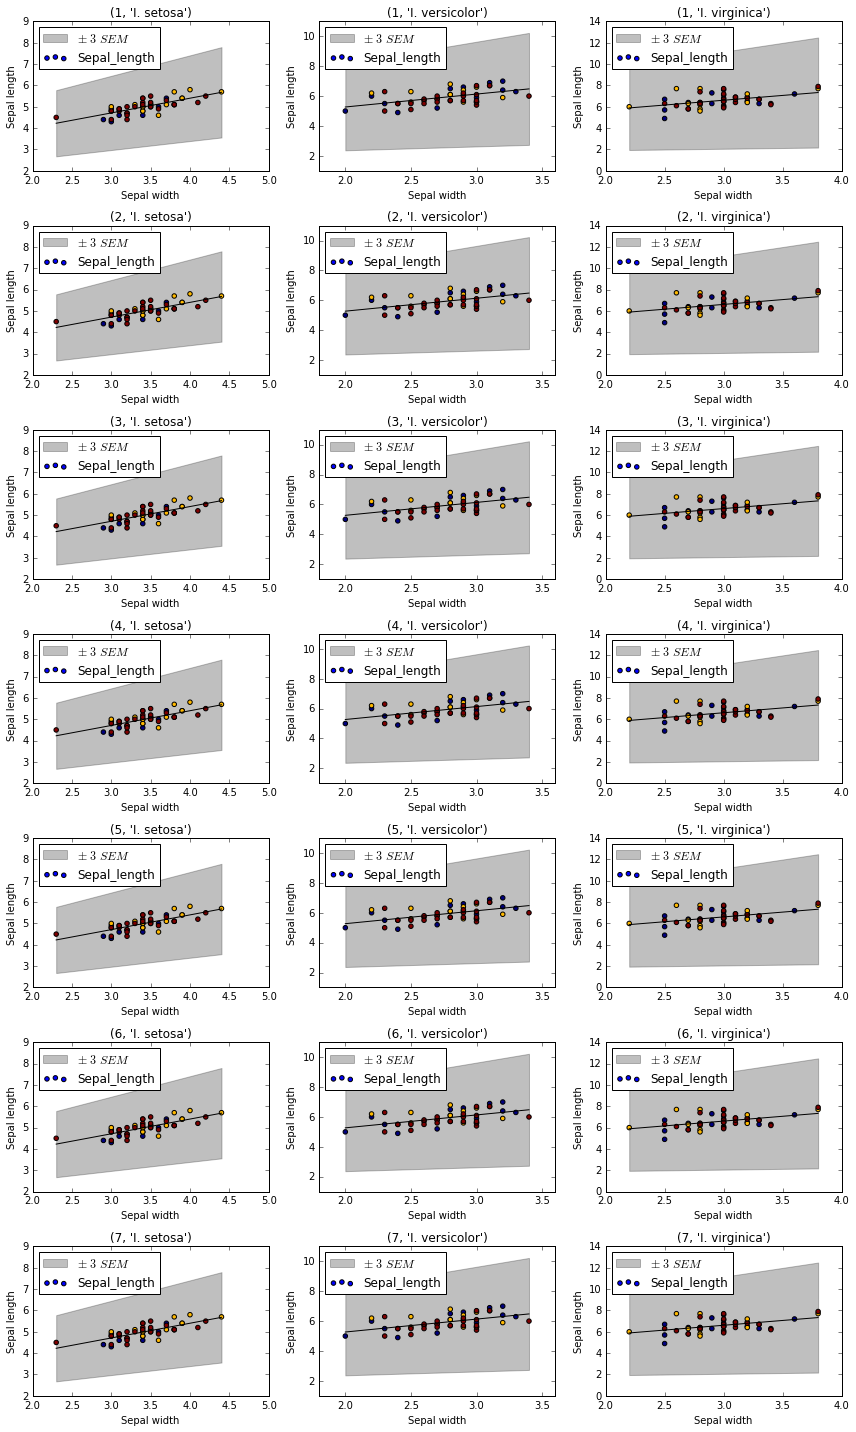

In [12]:
# create subplots based on subsets
fig, axs = plt.subplots(nrows=len(subset1), ncols=len(subset2),
                        figsize=(12,20), squeeze=False)
# create list with axes objects
axs = axs.ravel()

# set counter for axes
a=0


# nice! didn't know you can use groupby to subset as well
for comb, _df in df_iris.groupby(['Observer', 'Species']):   
    # fit model
    model = smf.ols('Sepal_length ~ Sepal_width', _df).fit()

    # get slope, intercepts and SEMs
    intercept, slope = model.params
    sem_intercept, sem_slope = 3*model.bse # 3 times the standard error of the regression line

    # create array with evenly spaced x values
    x1 = np.linspace(_df['Sepal_width'].min(), _df['Sepal_width'].max())

    # plot regression line
    axs[a].plot(x1, x1 * slope + intercept, 'k-')
    # plot regression line uncertainty
    axs[a].fill_between(x=x1, y1=x1 * (slope - sem_slope) + (intercept - sem_intercept),
                        y2=x1 * (slope + sem_slope) + (intercept + sem_intercept),
                        label='$\pm\ 3\ SEM$', alpha=.25, color='k')
    # plot data on top of sheded area
    axs[a].scatter(x=_df['Sepal_width'], y=_df['Sepal_length'],
                   c=_df['leave_spots'])

    # add labels etc
    axs[a].legend(loc='upper left')
    axs[a].set_title(comb)
    axs[a].set_ylabel('Sepal length') #Var4
    axs[a].set_xlabel('Sepal width') #Var5

    # increase axes counter
    a+=1

# adjust spacing
fig.tight_layout()

### Lets do it for one observer

0.3000667095184326


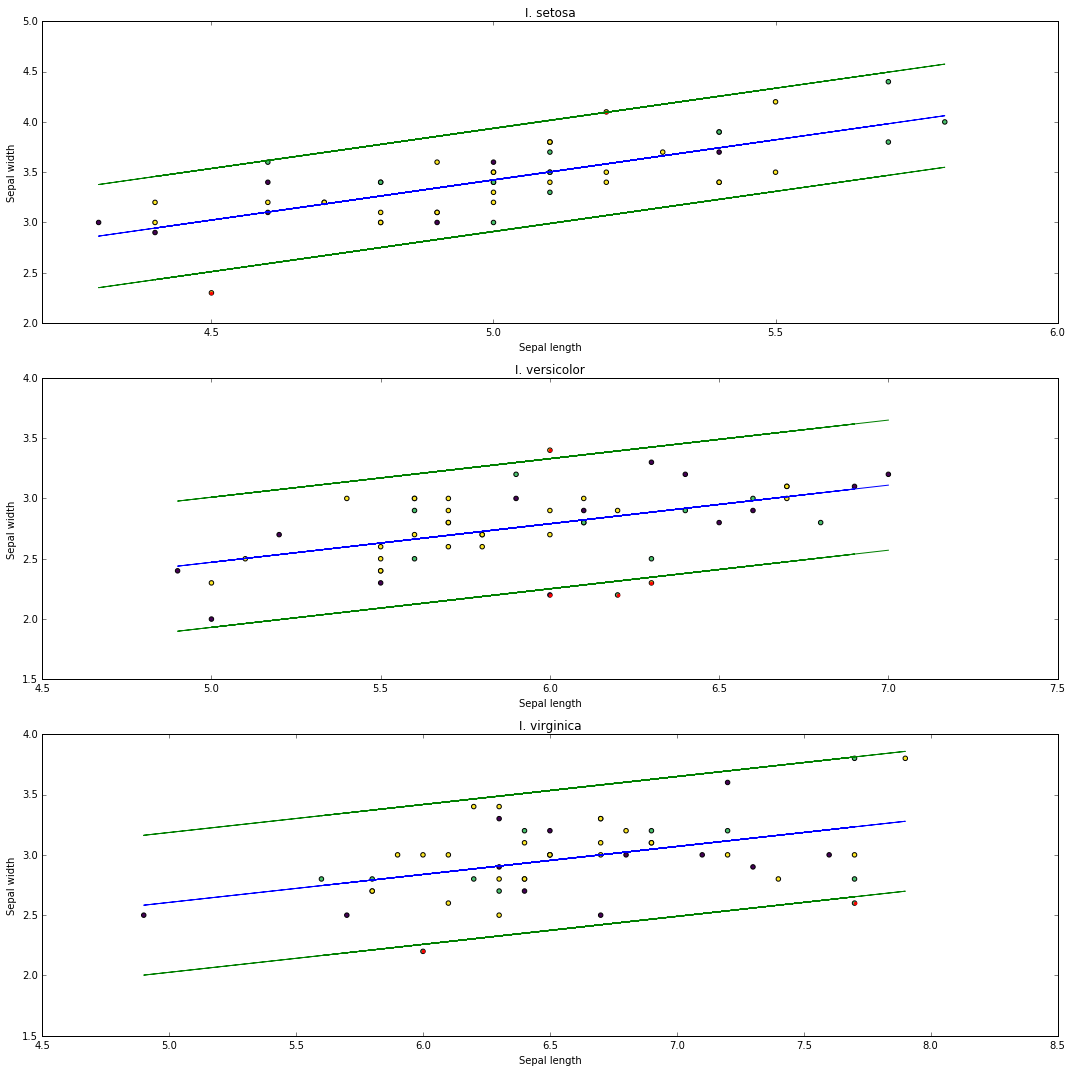

In [13]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import time
start = time.time()


df_iris = df_iris[df_iris["Observer"]==1]

# create subplots based on subsets
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(15,15), squeeze=False)

# create list with axes objects
axs = axs.ravel()

# set counter for axes
a=0

outlier_df = []  #lets say we want to get the outliers and color them differently and afterwards remove them


for comb, _df in df_iris.groupby(['Species']):    
    
    X = _df["Sepal_length"] ## X usually means our input variables (or independent variables)
    y = _df["Sepal_width"] ## Y usually means our output/dependent variable
    X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
    
    model = sm.OLS(y, X)
    
    results = model.fit()
    
 
    predicted = results.predict()
   
    upper = predicted + 2*(np.sqrt(results.scale))
    lower = predicted - 2*(np.sqrt(results.scale))
    
     
    
    for (row, value_l, value_u) in zip(_df.itertuples(), lower, upper): #for loop for outlier detection and coloring
        if getattr(row, "Sepal_width") < value_l:
            axs[a].plot(getattr(row, "Sepal_length"), getattr(row, "Sepal_width"), "r.")
        elif getattr(row, "Sepal_width") > value_u:
            axs[a].plot(getattr(row, "Sepal_length"), getattr(row, "Sepal_width"), "r.")
        else:
            outlier_df.append(row)

    xx = _df['Sepal_length']

    
    
    
    axs[a].scatter(x = _df["Sepal_length"], y=_df["Sepal_width"], c=_df['leave_spots'], cmap="viridis")
    
    axs[a].plot(xx, predicted, '-')
    
    axs[a].plot(xx, predicted + 2*(np.sqrt(results.scale)), '-', c='g') 
    
    axs[a].plot(xx, predicted - 2*(np.sqrt(results.scale)), '-', c='g' )
    axs[a].set_title(label=comb)
    axs[a].set_xlabel('Sepal length')
    axs[a].set_ylabel('Sepal width')
    
    a+=1

fig.tight_layout()
end = time.time()
print(end - start)

# Linear Regression, Orthogonal Regression

<img src="orthogonal_distance_linear_regression.jpg">


### The linear regression is not the best here. Lets use a orthogonal linear regression

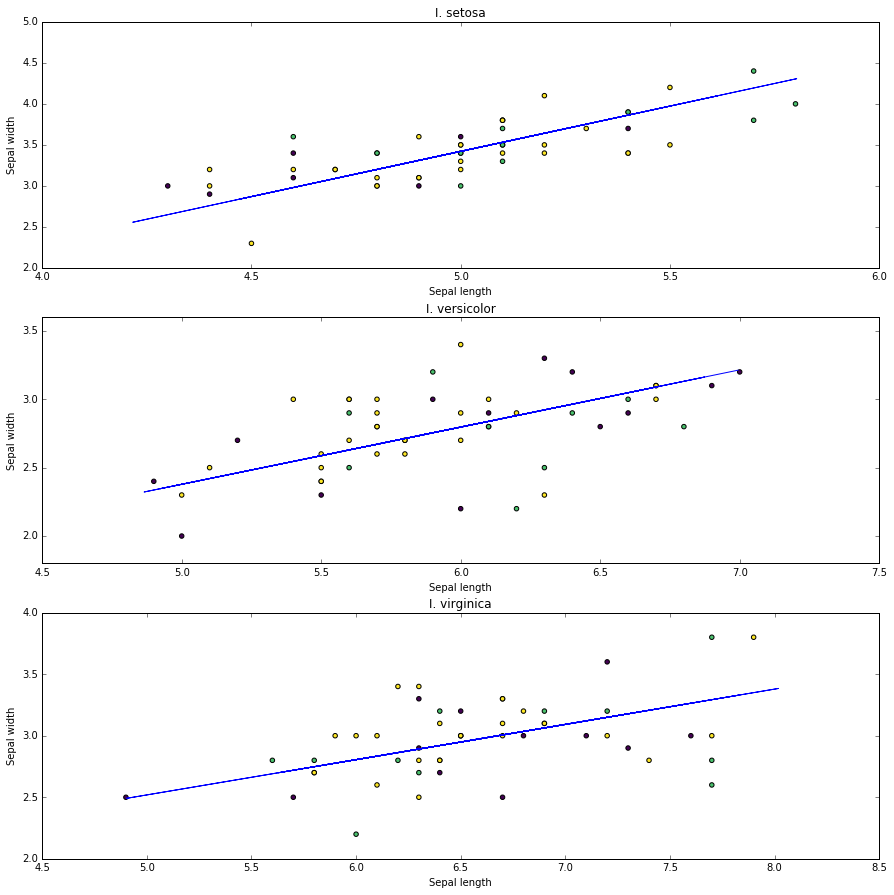

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
import random

df_iris = pd.read_csv("dummy_data.csv", sep=",")

df_iris = df_iris[df_iris["Observer"]==1]

fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(15,15), squeeze=False)

axs = axs.ravel()

# set counter for axes
a=0

outlier_df = []  #lets say we want to get the outliers and color them differently and afterwards remove them


for comb, _df in df_iris.groupby(['Species']): 
    # Initiate some data, giving some randomness using random.random().
    x = _df["Sepal length"] 
    y = _df["Sepal width"]


    # Define a function (quadratic in our case) to fit the data with.
    def linear_func(p, x):
       m, c = p
       return m*x + c

    # Create a model for fitting.
    linear_model = Model(linear_func)

    # Create a RealData object using our initiated data from above.
    data = Data(x, y)

    # Set up ODR with the model and data.
    odr = ODR(data, linear_model, beta0=[0., 1.])

    # Run the regression.
    out = odr.run()


    axs[a].scatter(x = _df["Sepal length"], y=_df["Sepal width"], c=_df['leave_spots'], cmap="viridis")    
    axs[a].plot(out.xplus, out.y, "-" )
    axs[a].set_title(label=comb)
    axs[a].set_xlabel('Sepal length')
    axs[a].set_ylabel('Sepal width')
    
    a+=1



In [30]:
data

# Lets do a linear regression, plot it, but in a function. 

In [15]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

df_iris = pd.read_csv("dummy_data.csv", sep=",")

df_iris = df_iris[df_iris["Observer"]==1]

def plot_linreg_Species(df, independVar, dependendVar):
    # create subplots based on subsets
    fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(15,15), squeeze=False)

    # create list with axes objects
    axs = axs.ravel()

    # set counter for axes
    a=0

    outlier_df = []  #lets say we want to get the outliers and color them differently and afterwards remove them


    for comb, _df in df.groupby(['Species']):    
    
        X = pd.DataFrame(_df[independVar]) ## X usually means our input variables (or independent variables)
        y = pd.DataFrame(_df[dependendVar]) ## Y usually means our output/dependent variable
    
        regressor = LinearRegression()

        reg = regressor.fit(X, y)
 
        predicted = reg.predict(X)
   
        upper = predicted + 2*(np.sqrt(metrics.mean_squared_error(y, predicted)))
        lower = predicted - 2*(np.sqrt(metrics.mean_squared_error(y, predicted)))
    
        for (row, value_l, value_u) in zip(_df.itertuples(), lower, upper): #for loop for outlier detection and coloring
            if getattr(row, dependendVar) < value_l:
                axs[a].plot(getattr(row, independVar), getattr(row, dependendVar), "r.")
            elif getattr(row, dependendVar) > value_u:
                axs[a].plot(getattr(row, independVar), getattr(row, dependendVar), "r.")
            else:
                outlier_df.append(row)

        xx = _df[independVar]

    
    
    
        axs[a].scatter(x = _df[independVar], y=_df[dependendVar], c=_df['leave_spots'], cmap="viridis")
    
        axs[a].plot(xx, predicted, '-')
    
        axs[a].plot(xx, predicted + 2*(np.sqrt(metrics.mean_squared_error(y, predicted))), '-', c='g') 
    
        axs[a].plot(xx, predicted - 2*(np.sqrt(metrics.mean_squared_error(y, predicted))), '-', c='g' )
        axs[a].set_title(label=comb)
        axs[a].set_xlabel(independVar)
        axs[a].set_ylabel(dependendVar)
    
        a+=1

    fig.tight_layout()

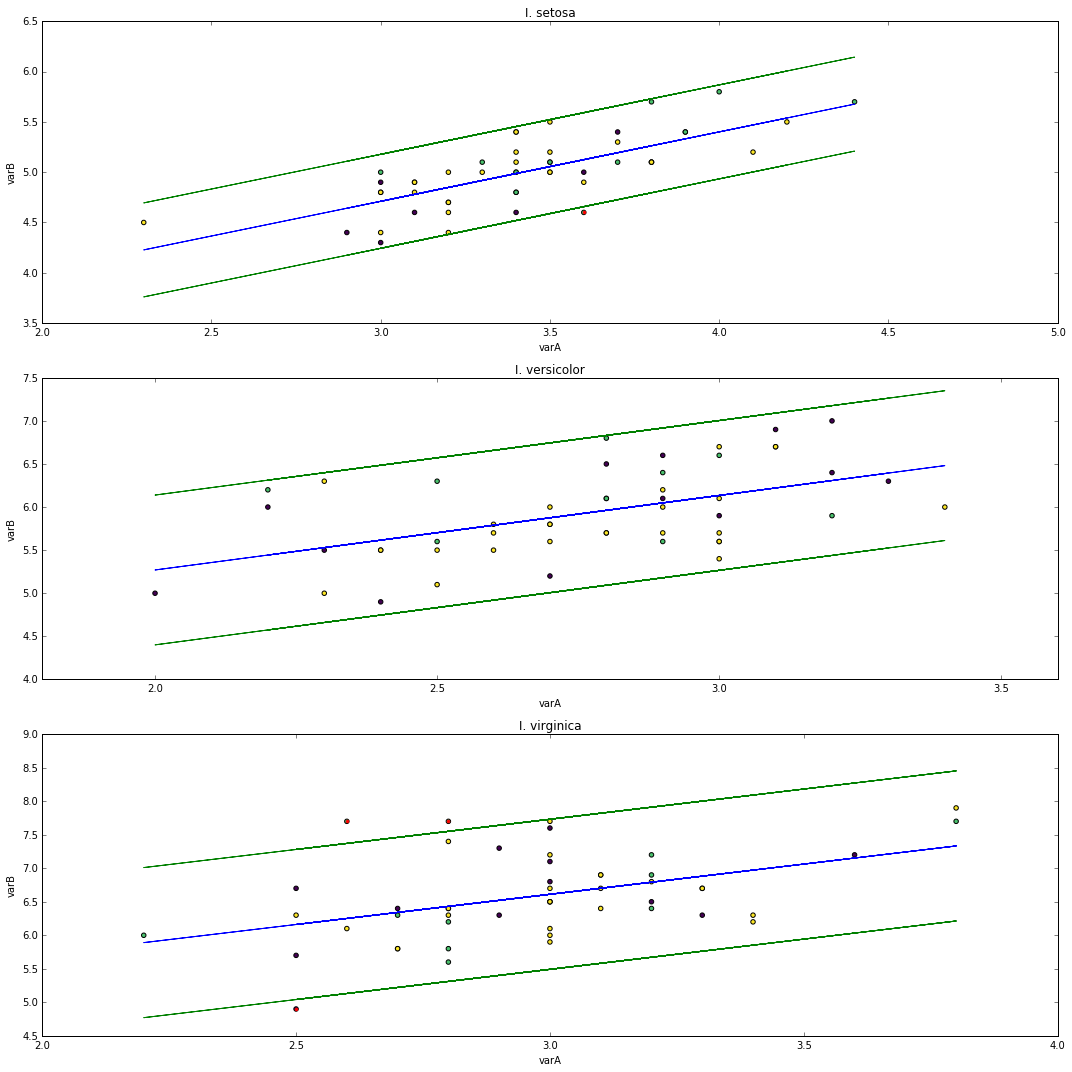

In [16]:
plot_linreg_Species(df_iris, "varA", "varB")

## Have a function which gives me all the parameters I need for each Species and different Variables

In [54]:
from sklearn import metrics
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm


df_iris = df_iris[df_iris["Observer"]==1]


def get_params_linreg(df, varInd, varDep):

    list_param = []
    for comb, _df in df.groupby(['Species']):    
    
        dic = {}
        X = _df[varInd] ## X usually means our input variables (or independent variables)
        y = _df[varDep] ## Y usually means our output/dependent variable
        X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model
    
        model = sm.OLS(y, X)
    
        results = model.fit()
        dic["Species"] = comb
        dic["SE"] = results.scale
        dic["m"] = results.params[0]
        dic["b"] = results.params[1]
        list_param.append(dic)
    
    return pd.DataFrame.from_records(list_param, index=["Species"])
         
   
    

In [55]:
k = get_params_linreg(df_iris, "varA", "varB")

In [56]:
k.head()

,SE,b,m
Species,,,
I. setosa,0.056902,0.690490,2.639001
I. versicolor,0.196758,0.865078,3.539735
I. virginica,0.326475,0.901534,3.906836


/home/robert/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/robert/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


1.3237278461456299


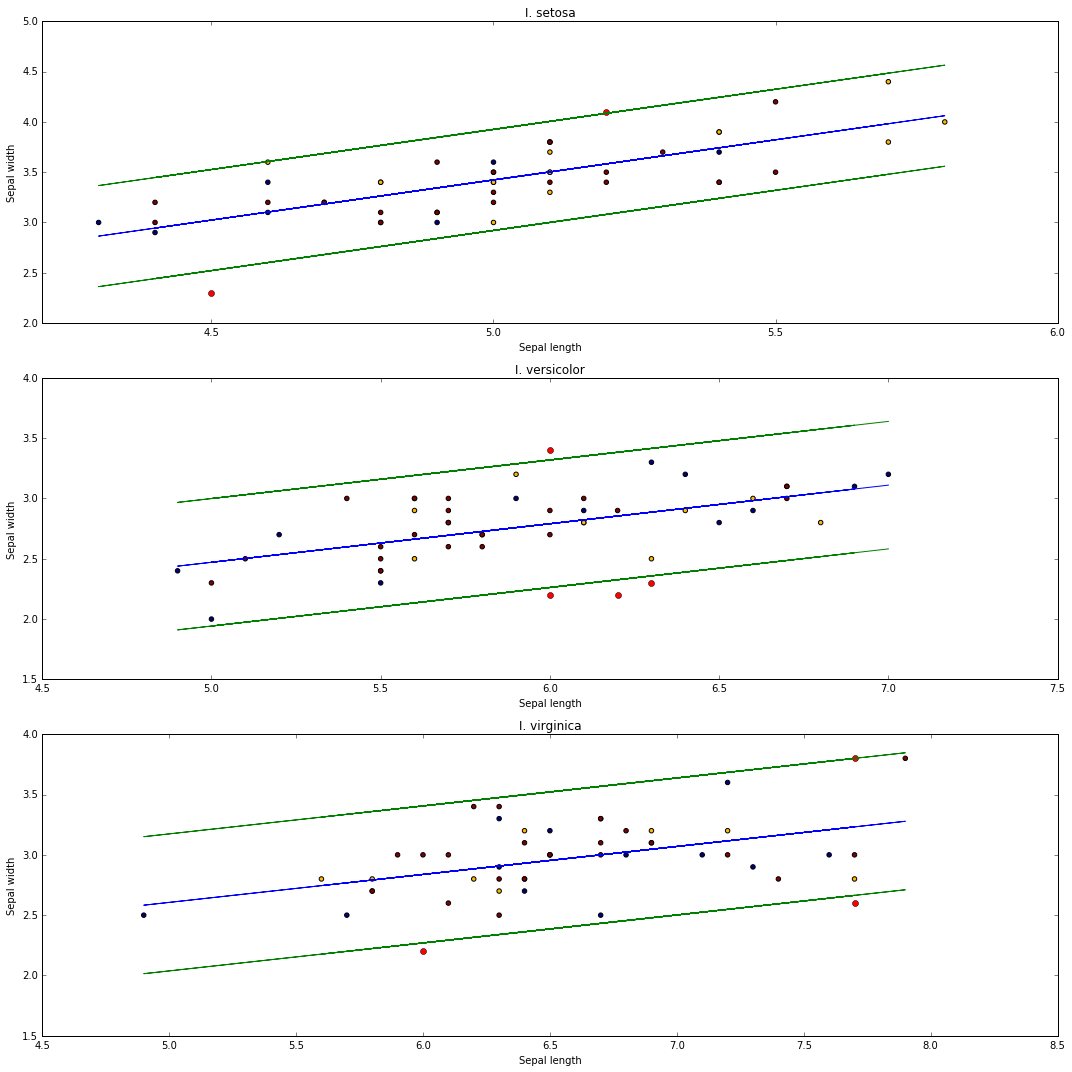

In [57]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import time
start = time.time()

df_iris = pd.read_csv("dummy_data.csv", sep=",")

df_iris = df_iris[df_iris["Observer"]==1]
df_iris = df_iris[['Sepal width', 'Sepal length', 'leave_spots', 'Species', 'Observer']]

# create subplots based on subsets
fig, axs = plt.subplots(nrows=3, ncols=1,figsize=(15,15), squeeze=False)

# create list with axes objects
axs = axs.ravel()

# set counter for axes
a=0

for comb, _df in df_iris.groupby(['Species']):    
    
    X = pd.DataFrame(_df["Sepal length"]) ## X usually means our input variables (or independent variables)
    y = pd.DataFrame(_df["Sepal width"]) ## Y usually means our output/dependent variable
    
    regressor = LinearRegression()
    reg = regressor.fit(X, y) 
    predicted = reg.predict(X)
   
    upper = predicted + 2*(np.sqrt(metrics.mean_squared_error(y, predicted)))
    lower = predicted - 2*(np.sqrt(metrics.mean_squared_error(y, predicted)))    
     

    _df['upper'] = predicted + 2*(np.sqrt(metrics.mean_squared_error(y, predicted)))
    _df['lower'] = predicted - 2*(np.sqrt(metrics.mean_squared_error(y, predicted)))

    outlier = _df[(_df["Sepal width"] < _df['lower']) | (_df["Sepal width"] > _df['upper'])]
    inlier = _df[(_df["Sepal width"] >= _df['lower']) & (_df["Sepal width"] <= _df['upper'])]
    
    axs[a].plot(outlier["Sepal length"], outlier["Sepal width"], "ro")
    axs[a].scatter(x=inlier["Sepal length"], y=inlier["Sepal width"], c=inlier['leave_spots'])
  
    axs[a].plot(_df['Sepal length'], predicted, '-')    
    axs[a].plot(_df['Sepal length'], predicted + 2*(np.sqrt(metrics.mean_squared_error(y, predicted))), '-', c='g')    
    axs[a].plot(_df['Sepal length'], predicted - 2*(np.sqrt(metrics.mean_squared_error(y, predicted))), '-', c='g' )
    
    axs[a].set_title(label=comb)
    axs[a].set_xlabel('Sepal length')
    axs[a].set_ylabel('Sepal width')
    
    a+=1

fig.tight_layout()
end = time.time()
print(end - start)